In [0]:
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as torchdist
import torch.nn as nn
import torch.nn.functional as F
import itertools
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler

In [2]:
x = torch.tensor([1., 2., 3.], requires_grad=True)
y = - 2*x + 2
loss = y.mean()


loss.backward()
print(loss)
print(x.grad)

tensor(-2., grad_fn=<MeanBackward0>)
tensor([-0.6667, -0.6667, -0.6667])


In [0]:
normal_dist = torchdist.Normal(loc=torch.tensor(0.), scale=torch.tensor(1.))

In [0]:
x = normal_dist.sample()

In [5]:
x

tensor(-1.1633)

In [0]:
x = normal_dist.sample([100])

In [7]:
x

tensor([ 0.7176,  0.7875, -1.0450, -1.0880,  0.6338,  0.0638, -0.1421, -1.5516,
        -0.4203, -0.4884,  1.2134, -0.2616,  1.0978, -0.1536,  0.2361, -1.7389,
         0.0677,  0.2455,  1.3653, -0.3311, -1.1249, -0.4979, -0.3671, -1.1101,
        -0.6793, -1.5149,  0.8415,  0.8318, -1.1590,  0.2680, -0.8280, -0.4499,
        -0.0746, -1.3415, -0.7082,  0.1255,  0.5114,  1.5247,  0.5709, -0.1615,
        -1.2992, -2.1411, -2.1242, -0.1964,  0.0306,  0.5368,  1.0270,  0.6433,
        -2.1179, -0.1193, -1.7845, -0.2055,  0.0825,  0.1521,  0.1837, -1.3152,
         1.8508,  0.1427, -0.0293,  0.3428, -0.3671,  0.4262,  0.6435, -0.7293,
         0.4646, -0.3417, -0.1088, -0.4001,  1.0656, -0.6416,  0.2840,  0.0987,
        -0.0935,  1.1079,  0.6413,  0.7379, -0.8857,  1.1964, -0.2614,  0.1920,
         0.8002, -1.0080, -1.7792, -1.5931, -0.2673, -1.0484,  0.7604, -0.0179,
        -0.9082,  0.9920,  2.0099, -0.2575, -0.6555,  0.8035, -1.1301,  0.3129,
        -1.2775, -0.3695, -1.0376, -0.79

(array([ 6.,  5., 12., 10., 21., 18., 12., 10.,  4.,  2.]),
 array([-2.141126  , -1.72602   , -1.310914  , -0.8958081 , -0.48070216,
        -0.06559622,  0.34950972,  0.76461565,  1.1797216 ,  1.5948275 ,
         2.0099335 ], dtype=float32),
 <a list of 10 Patch objects>)

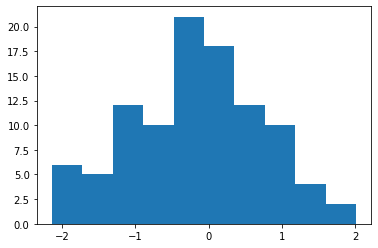

In [8]:
plt.hist(x.detach().numpy())

In [0]:
def toy_poly():
    x = 5 * torch.rand(100, 1)
    # linear_op = -3 - 4*x + x**2
    # linear_op = -3 - 4*x + 2*x**2 - x*x*x / 5
    linear_op = 4 * torch.sin(x*2)
    y = torchdist.Normal(linear_op, 0.5).sample()
    return x, y

x_train, y_train = toy_poly()

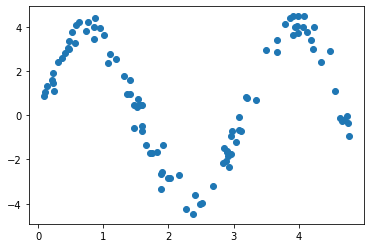

In [10]:
plt.plot(x_train.numpy(), y_train.numpy(), 'o')

### Normalizing Flows

Calculate prediction distribution

\begin{align}
q(z') = q(z) \left| \mathrm{det} \frac{\partial f}{\partial z'} \right| = q(z) \left| \mathrm{det} \frac{\partial f}{\partial z} \right|^{-1}
\end{align}

\begin{align}
\ln q_K(z_K) = \ln q_0(z_0) - \sum_{k=1}^{K} \ln \left| \mathrm{det} \frac{\partial f_k}{\partial z_k} \right|
\end{align}

planar flow
\begin{align}
f(z) = z + uh(w^\top z + b)
\end{align}
\begin{align}
\mathrm{det} \left| \frac{\partial f}{\partial z} \right| = |\mathrm{det}(I + u\psi(z)^\top)| = |1 + u^\top \psi(z)|
\end{align}
\begin{align}
\psi(z) = h'(w^\top z + b)w
\end{align}

In [0]:
class CustomNormal(torch.distributions.Normal):
    def __init__(self, loc, scale, validate_args=None, eps=1e-6):
        super(CustomNormal, self).__init__(loc, scale, validate_args)
        self.eps = eps

    def __getattribute__(self, name):        
        if name == 'scale':            
            # return torch.exp(object.__getattribute__(self, name)).clamp(min=self.eps)
            return torch.exp(object.__getattribute__(self, name)) + self.eps
        else:            
            return object.__getattribute__(self, name)


In [0]:
class CustomMultivariateNormal(torch.distributions.MultivariateNormal):
    def __init__(self, loc, covariance_matrix=None, precision_matrix=None, scale_tril=None, validate_args=None):
        super(CustomMultivariateNormal, self).__init__(
            loc, covariance_matrix, precision_matrix, scale_tril, validate_args)
        self.eps = torch.eye(loc.size(0)) * 1e-4

    def __getattribute__(self, name):        
        if name == '_unbroadcasted_scale_tril':            
            # return F.relu(object.__getattribute__(self, name)) + 1e-4
            # return F.relu(object.__getattribute__(self, name)).clamp(min=1e-8)
            return F.relu(object.__getattribute__(self, name)) + self.eps
            # return torch.exp(object.__getattribute__(self, name))
        else:            
            return object.__getattribute__(self, name)

In [0]:
class PlanarFlow(nn.Module):
    def __init__(self, n, u_normalize=False):
        super().__init__()
        self.u = nn.Parameter(torch.randn(1, n).normal_(0, 0.01))
        self.w = nn.Parameter(torch.randn(1, n).normal_(0, 0.01))
        self.b = nn.Parameter(torch.zeros(1))

        torch.nn.init.kaiming_normal_(self.u)
        torch.nn.init.kaiming_normal_(self.w)

        self.u_normalize = u_normalize

    def forward(self, z):
        u_hat = self.norm_u() if self.u_normalize else self.u        

        f_z = z + u_hat * torch.tanh(z @ self.w.t() + self.b)
        f_z = f_z.squeeze()
        return f_z

    def log_det(self, z):
        u_hat = self.norm_u() if self.u_normalize else self.u        

        psi = (1 - torch.tanh(z @ self.w.t() + self.b)**2) * self.w
        det = 1 + u_hat @ psi.t()
        log_abs_det_jacobians = torch.log(torch.abs(det) + 1e-6).squeeze()

        return log_abs_det_jacobians

    def norm_u(self):
        wtu = (self.w @ self.u.t()).squeeze()
        m_wtu = - 1 + torch.log1p(wtu.exp())
        u_hat = self.u + (m_wtu - wtu) * self.w / (self.w @ self.w.t())

        return u_hat

class FlowDistribution(nn.Module):
    def __init__(self, loc, scale):
        super().__init__()

        self.normal = CustomNormal(loc=loc, scale=scale)
        n_dims = loc.size(0)
        self.flows = nn.ModuleList([PlanarFlow(n_dims, u_normalize=False) for _ in range(32)])        

    def sample(self):
        with torch.no_grad():        
            zs = self.rsample()
        return zs

    def rsample(self):
        zs = []
        z = self.normal.rsample()

        zs.append(z)
        for flow in self.flows:
            z = flow(z)
            zs.append(z)

        return zs

    def log_prob(self, zs):
        # zs
        z_0 = zs[0]
        z_ks = zs[1:]

        if len(self.flows) != len(z_ks):
            raise ValueError

        sum_log_det = 0
        for flow, z in zip(self.flows, z_ks):
            sum_log_det += flow.log_det(z)

        return self.normal.log_prob(z_0).sum() - sum_log_det

def transform_param(w, loc_dict):
    param_dict = OrderedDict()
    for n, loc_info in loc_dict.items():
        loc = loc_info['loc']
        size = loc_info['size']
        sample = w[slice(*loc)]
        param_dict[n] = sample.view(*size)

    return param_dict


class VIModel2(nn.Module):
    def __init__(self, model):
        super(VIModel2, self).__init__()
        self.loc_dict, n_dim = self.extract_param(model)
        
        self.mu = nn.Parameter(torch.zeros(n_dim))        
        self.log_sigma = nn.Parameter(torch.zeros(n_dim))
        
        self.dist = FlowDistribution(loc=self.mu, scale=self.log_sigma)

    def extract_param(self, model):
        start = 0
        loc_dict = OrderedDict()
        for n, p in model.named_parameters():
            num = reduce(lambda x, y: x*y, p.size())
            end = start + num
            loc_info = {
                'size': p.size(),
                'loc': (start, end)
            }
            start = end
            
            loc_dict[n] = loc_info
        
        n_dim = start
        print(loc_dict)
        print(n_dim)
        return loc_dict, n_dim

def normal_prior_distV2(model):
    n_dim = 0
    for n, p in model.named_parameters():
        num = reduce(lambda x, y: x*y, p.size())
        n_dim += num

    mu = torch.zeros(n_dim)
    # log_sigma = torch.zeros(n_dim)
    # dist = CustomNormal(loc=mu, scale=log_sigma)
    sigma = torch.ones(n_dim) * 10
    dist = torchdist.Normal(loc=mu, scale=sigma)
    # sigma = torch.eye(n_dim) * 10
    # dist = torchdist.MultivariateNormal(loc=mu, scale_tril=sigma)
    # dist = CustomMultivariateNormal(loc=mu, scale_tril=sigma)
    return dist

def kl_divergenceV2(q_w, p_w, loc_dict, model, x, y, idx):

    # sampling from q(w)
    zs = q_w.rsample()
    # z_0 = zs[0]
    w_sample = zs[-1]

    param_dict = transform_param(w_sample, loc_dict)
    model.set_params(param_dict)

    # calculate f(x)
    # p(y|x,w) = N(f(x; w), 1)
    out1, out2 = model(x)
    if out1.size(-1) != 1:
        raise ValueError
    
    p_y_xw = torchdist.Normal(out1, torch.ones_like(out1) / 2)
    # p_y_xw = torchdist.Normal(out1, out2)

    temp = lambda i: min(1, 0.01 + i/10000)

    # log(p(w, x, y)) = log(p(w)) + sum(log(p(y|x,w)))
    val_log_p_w = p_w.log_prob(w_sample).sum()  
    val_log_p_y_xw = p_y_xw.log_prob(y).sum()
    val_log_q_w = q_w.log_prob(zs)
    # val_log_q_w = -q_w.entropy()    

    if (idx+1) % 100 == 0:
        out_desc = out1.detach()
        print('%d loss q(w) %f p(w) %f p(y|xw) %f min %f mean %f max %f' 
              % (idx, val_log_q_w.item(), val_log_p_w.item(), val_log_p_y_xw.item(), 
                 out_desc.min(), out_desc.mean(), out_desc.max()))
    
    # return val_log_q_w - temp(idx) * (val_log_p_w + val_log_p_y_xw)
    return val_log_q_w -  (val_log_p_w + val_log_p_y_xw)
    # return val_log_q_w - val_log_p_y_xw
    # return - val_log_p_y_xw

## module

In [0]:
class TensorModule:
    def __init__(self):
        self.training = True
        self._parameters = OrderedDict()
        self._modules = OrderedDict()
        self._tmodules = OrderedDict()
        self._buffers = OrderedDict()

    def __call__(self, *input, **kwargs):
        result = self.forward(*input, **kwargs)
        return result
    
    def forward(self, *input):
        raise NotImplementedError

    def __setattr__(self, name, value):
        def remove_from(*dicts):
            for d in dicts:
                if name in d:
                    del d[name]

        params = self.__dict__.get('_parameters')
        if name.startswith('p_') and isinstance(value, torch.Tensor):
            if params is None:
                raise AttributeError
            remove_from(self.__dict__, self._buffers, self._modules)
            self.register_parameter(name, value)
        elif params is not None and name in params:
            if value is not None:
                raise TypeError
            self.register_parameter(name, value)
        else:
            modules = self.__dict__.get('_modules')
            if isinstance(value, TensorModule):
                if modules is None:
                    raise AttributeError
                remove_from(self.__dict__, self._parameters, self._buffers)
                modules[name] = value
            elif modules is not None and name in modules:
                if value is not None:
                    raise TypeError
                modules[name] = value
            else:
                buffers = self.__dict__.get('_buffers')
                if buffers is not None and name in buffers:
                    if value is not None and not isinstance(value, torch.Tensor):
                        raise TypeError
                    buffers[name] = value
                else:
                    object.__setattr__(self, name, value)

    def __getattr__(self, name):
        if '_parameters' in self.__dict__:
            _parameters = self.__dict__['_parameters']
            if name in _parameters:
                return _parameters[name]

        if '_buffers' in self.__dict__:
            _buffers = self.__dict__['_buffers']
            if name in _buffers:
                return _buffers[name]
        
        if '_modules' in self.__dict__:
            _modules = self.__dict__['_modules']
            if name in _modules:
                return _modules[name]

    def register_parameter(self, name, param):
        # debug
        if name in self._parameters:
            prev_param = self._parameters[name]
        else:
            prev_param = None
        # print('%s: %s -> %s' % (name, str(prev_param), str(param)))

        if '.' in name:
            raise KeyError

        if param is None:
            self._parameters[name] = None
        elif not isinstance(param, torch.Tensor):
            raise TypeError
        else:
            self._parameters[name] = param

    def register_buffer(self, name, tensor):
        if '.' in name:
            raise KeyError
        elif tensor is not None and not isinstance(tensor, torch.Tensor):
            raise TypeError
        else:
            self._buffers[name] = tensor

    def named_modules(self, memo=None, prefix=''):
        if memo is None:
            memo = set()
        if self not in memo:
            memo.add(self)
            yield prefix, self
            for name, module in self._modules.items():
                if module is None:
                    continue
                submodule_prefix = prefix + ('.' if prefix else '') + name
                for m in module.named_modules(memo, submodule_prefix):
                    yield m   

    def _named_members(self, get_members_fn, prefix='', recurse=True):
        memo = set()
        modules = self.named_modules(prefix=prefix) if recurse else [(prefix, self)]
        for module_prefix, module in modules:
            members = get_members_fn(module)
            for k, v in members:
                if v is None or v in memo:
                    continue
                memo.add(v)
                name = module_prefix + ('.' if module_prefix else '') + k
                yield name, v

    def named_parameters(self, prefix='', recurse=True):
        gen = self._named_members(
            lambda module: module._parameters.items(),
            prefix=prefix, recurse=True
        )
        for elem in gen:
            yield elem

    def _load_from_state_dict(self, state_dict, prefix):
        local_name_params = itertools.chain(self._parameters.items(), self._buffers.items())
        local_state = {k: v for k, v in local_name_params if v is not None}

        for name, param in local_state.items():
            key = prefix + name
            if key in state_dict:
                input_param = state_dict[key]
                setattr(self, name, input_param)
                # with torch.no_grad():                        
                # param.copy_(input_param)

    def set_params(self, state_dict):
        def load(module, prefix=''):
            module._load_from_state_dict(state_dict, prefix)
        
            for name, child in module._modules.items():
                if child is not None:
                    load(child, prefix + name + '.')
        load(self)
        load = None
        
    def train(self, mode=True):
        self.training =  mode
        for module in self.children():
            module.train(mode)
        return self

    def eval(self):
        return self.train(False)

    def children(self):
        for name, module in self.named_children():
            yield module

    def named_children(self):
        memo = set()
        for name, module in self._modules.items():
            if module is not None and module not in memo:
                memo.add(module)
                yield name, module

class TensorLinear(TensorModule):
    def __init__(self, in_features, out_features, bias=True):
        super(TensorLinear, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        # self.weight = TensorParameter((out_features, in_features))
        self.p_weight = torch.zeros((out_features, in_features), dtype=torch.float32)
        if bias:
            self.p_bias = torch.zeros((out_features, ), dtype=torch.float32)
        else:
            # original self.register_parameter('bias', None)
            self.p_bias = None

    def forward(self, input):
        return F.linear(input, self.p_weight, self.p_bias)

In [0]:
class _NormBase(TensorModule):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True,
                 track_running_stats=True):
        super(_NormBase, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        if self.affine:
            self.p_weight = torch.Tensor(num_features)
            self.p_bias = torch.Tensor(num_features)
        else:
            self.register_parameter('p_weight', None)
            self.register_parameter('p_bias', None)
        if self.track_running_stats:
            self.register_buffer('running_mean', torch.zeros(num_features))
            self.register_buffer('running_var', torch.ones(num_features))
            self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))
        else:
            self.register_parameter('running_mean', None)
            self.register_parameter('running_var', None)
            self.register_parameter('num_batches_tracked', None)
        self.reset_parameters()

    def reset_running_stats(self):
        if self.track_running_stats:
            self.running_mean.zero_()
            self.running_var.fill_(1)
            self.num_batches_tracked.zero_()

    def reset_parameters(self):
        self.reset_running_stats()
        if self.affine:
            torch.nn.init.ones_(self.p_weight)
            torch.nn.init.zeros_(self.p_bias)

class _BatchNorm(_NormBase):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True, 
                 track_running_stats=True):
        super(_BatchNorm, self).__init__(num_features, eps, momentum, affine,
                                         track_running_stats)
    
    def forward(self, input):
        self._check_input_dim(input)

        if self.momentum is None:
            exponential_average_factor = 0.0
        else:
            exponential_average_factor = self.momentum

        if self.training and self.track_running_stats:            
            if self.num_batches_tracked is not None:
                self.num_batches_tracked = self.num_batches_tracked + 1
                if self.momentum is None:  # use cumulative moving average
                    exponential_average_factor = 1.0 / float(self.num_batches_tracked)
                else:  # use exponential moving average
                    exponential_average_factor = self.momentum

        return F.batch_norm(
            input, self.running_mean, self.running_var, self.p_weight, self.p_bias,
            self.training or not self.track_running_stats,
            exponential_average_factor, self.eps)
        

class TensorBatchNorm1d(_BatchNorm):
    def _check_input_dim(self, input):
        if input.dim() != 2 and input.dim() !=3:
            raise ValueError('invalid dim')

In [0]:
class TensorLinearNet(TensorModule):
    def __init__(self):
        super(TensorLinearNet, self).__init__()
        n = 4
        self.linear1 = TensorLinear(1, n)
        self.linear2 = TensorLinear(n, n)
        self.linear3 = TensorLinear(n, n)
        self.linear4 = TensorLinear(n, n)

        self.last_layer = TensorLinear(n, 1)

        self.bn1 = TensorBatchNorm1d(n, affine=False)
        self.bn2 = TensorBatchNorm1d(n, affine=False)
        self.bn3 = TensorBatchNorm1d(n, affine=False)
        self.bn4 = TensorBatchNorm1d(n, affine=False)

    def forward(self, x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.linear2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.linear3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.linear4(x)
        x = self.bn4(x)
        x = F.relu(x)

        x = self.last_layer(x)

        x1 = x
        x2 = None

        return x1, x2

## model

In [0]:
def kl_divergence_nsamples(q_w, p_w, loc_dict, model, x, y, idx):

    val_loss = 0
    n_samples = 30
    for _ in range(n_samples):
        val_loss += kl_divergenceV2(q_w, p_w, loc_dict, model, x, y, idx) / n_samples
    return val_loss


def write_graph(writer, model, x):
    writer.add_graph(model, input_to_model=x)

def predict(q_w, loc_dict, model, x, n_samples):    
    
    approx_y = 0  
    # model.eval()
    with torch.no_grad():
        for i in range(n_samples):
            # sampling from q(w)
            w_sample = q_w.sample()[-1]

            param_dict = transform_param(w_sample, loc_dict)
            model.set_params(param_dict)
            # calculate f(x)
            out1, out2 = model(x)
            
            y_sample = out1

            approx_y += y_sample / n_samples
    
    return approx_y

def plt_prediction(q_w, loc_dict, model, x, y_true, n_smaples):
    y_pred = predict(q_w, loc_dict, model, x, n_smaples)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(x.numpy(), y_true.numpy(), 'o')
    axes[0].plot(x.numpy(), y_pred.numpy(), 'o')
    plt.show()

## exec

Calculate prediction distribution
$$
\begin{align}
& KL[q(W; \eta)||p(W|X, Y)] \\
&= \int q(W; \eta) \log \frac{q(W; \eta)}{p(W|X, Y)} dW\\
&= \int q(W; \eta) \log q(W; \eta)dW - \int q(W; \eta) \log \frac{p(Y|W, X)p(W)}{p(Y|X)}dW \\
&= \int q(W; \eta) \log q(W; \eta)dW - \int q(W; \eta) \log p(Y|W, X)dW - \int q(W; \eta) \log p(W)dW + const.\\
&= E[\log q(W; \eta)] - E[\log p(Y|W, X)] - E[\log p(W)] + const.
\end{align}
$$

\begin{align}
E[\log p(Y|W, X)] = E\left[\sum log p(y_i|W, x_i)\right]
\end{align}

OrderedDict([('linear1.p_weight', {'size': torch.Size([4, 1]), 'loc': (0, 4)}), ('linear1.p_bias', {'size': torch.Size([4]), 'loc': (4, 8)}), ('linear2.p_weight', {'size': torch.Size([4, 4]), 'loc': (8, 24)}), ('linear2.p_bias', {'size': torch.Size([4]), 'loc': (24, 28)}), ('linear3.p_weight', {'size': torch.Size([4, 4]), 'loc': (28, 44)}), ('linear3.p_bias', {'size': torch.Size([4]), 'loc': (44, 48)}), ('linear4.p_weight', {'size': torch.Size([4, 4]), 'loc': (48, 64)}), ('linear4.p_bias', {'size': torch.Size([4]), 'loc': (64, 68)}), ('last_layer.p_weight', {'size': torch.Size([1, 4]), 'loc': (68, 72)}), ('last_layer.p_bias', {'size': torch.Size([1]), 'loc': (72, 73)})])
73
99 loss q(w) -99.714294 p(w) -236.789337 p(y|xw) -664.915405 min -3.384802 mean 1.155527 max 2.594073
99 loss q(w) -97.101120 p(w) -236.920822 p(y|xw) -537.845886 min -5.479810 mean -0.190337 max 2.168585
99 loss q(w) -109.341713 p(w) -236.695160 p(y|xw) -751.008362 min -5.102763 mean 0.058787 max 1.807944
99 loss q

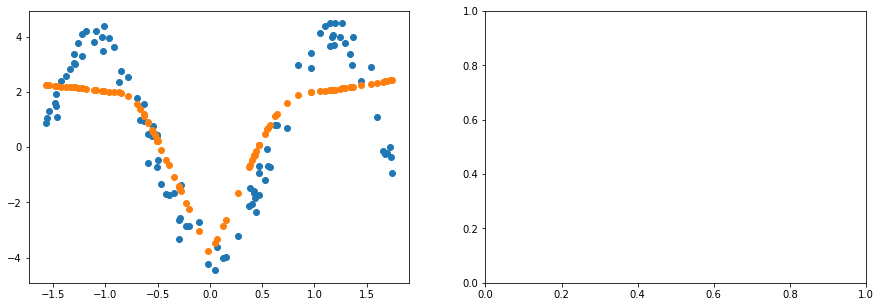

199 loss q(w) -92.786209 p(w) -237.941193 p(y|xw) -278.745514 min -3.687078 mean 0.594254 max 2.812898
199 loss q(w) -92.773613 p(w) -238.061722 p(y|xw) -511.308350 min -7.455134 mean 0.068319 max 3.404699
199 loss q(w) -86.979691 p(w) -237.816818 p(y|xw) -378.055664 min -4.925817 mean -0.026228 max 2.789037
199 loss q(w) -81.784027 p(w) -237.692673 p(y|xw) -499.946014 min -4.668678 mean 1.106770 max 4.203257
199 loss q(w) -92.522125 p(w) -237.115646 p(y|xw) -260.555389 min -1.931048 mean 1.011900 max 3.786606
199 loss q(w) -81.104591 p(w) -237.689880 p(y|xw) -314.592072 min -4.083479 mean 0.578690 max 3.070418
199 loss q(w) -88.715698 p(w) -237.444031 p(y|xw) -241.525909 min -4.276033 mean 0.962270 max 4.620787
199 loss q(w) -103.258705 p(w) -237.695343 p(y|xw) -482.781006 min -6.690575 mean 0.563942 max 4.180344
199 loss q(w) -94.545006 p(w) -237.926300 p(y|xw) -343.878479 min -3.568864 mean 1.569874 max 3.759991
199 loss q(w) -87.056061 p(w) -237.744614 p(y|xw) -230.636490 min -5.44

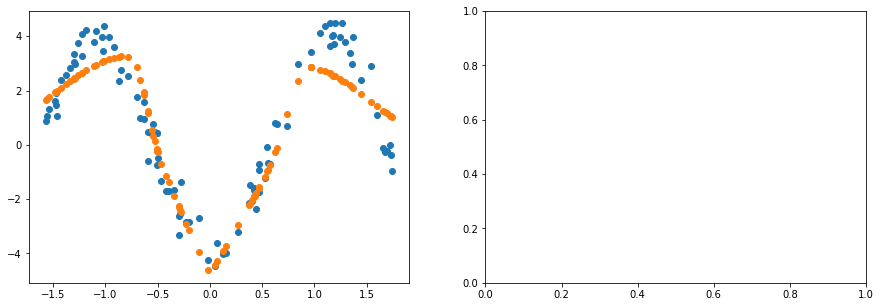

299 loss q(w) -85.243515 p(w) -238.399826 p(y|xw) -169.270401 min -4.248158 mean 0.405691 max 3.362979
299 loss q(w) -89.267036 p(w) -238.600815 p(y|xw) -170.684647 min -5.248058 mean 0.342748 max 3.513043
299 loss q(w) -83.365295 p(w) -238.566162 p(y|xw) -171.904465 min -4.221054 mean 0.755812 max 4.492682
299 loss q(w) -80.521004 p(w) -238.094131 p(y|xw) -165.463989 min -4.890818 mean 0.497199 max 3.175674
299 loss q(w) -81.862373 p(w) -238.180908 p(y|xw) -184.714005 min -3.791474 mean 1.394500 max 4.419838
299 loss q(w) -85.486740 p(w) -238.002487 p(y|xw) -286.640900 min -2.546195 mean 1.169660 max 3.729835
299 loss q(w) -93.840538 p(w) -237.668472 p(y|xw) -543.622070 min -1.821106 mean 1.616180 max 4.259736
299 loss q(w) -89.224236 p(w) -238.290298 p(y|xw) -143.597794 min -3.299784 mean 0.821335 max 3.706228
299 loss q(w) -93.690643 p(w) -238.213364 p(y|xw) -226.647324 min -3.498205 mean 1.019913 max 4.221206
299 loss q(w) -93.954239 p(w) -238.274353 p(y|xw) -135.864502 min -4.9601

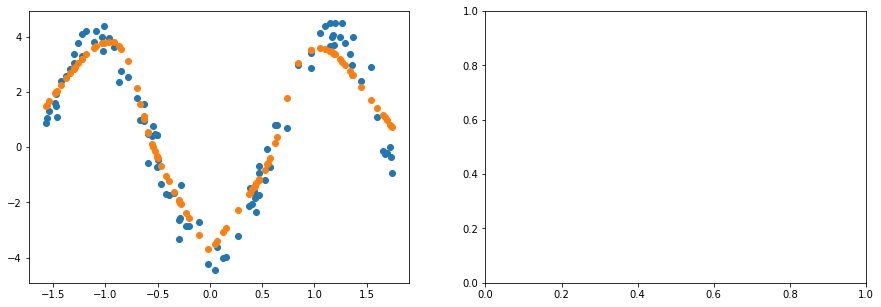

399 loss q(w) -91.864441 p(w) -238.461609 p(y|xw) -217.122101 min -2.770694 mean 1.335680 max 4.168368
399 loss q(w) -98.171860 p(w) -238.854599 p(y|xw) -140.929932 min -4.531683 mean 0.648166 max 3.588193
399 loss q(w) -86.276917 p(w) -238.911743 p(y|xw) -105.710457 min -3.755299 mean 0.971698 max 4.033427
399 loss q(w) -76.015419 p(w) -238.565979 p(y|xw) -129.010025 min -4.966601 mean 0.979505 max 3.844723
399 loss q(w) -86.920845 p(w) -238.647125 p(y|xw) -176.388626 min -2.594271 mean 0.932739 max 4.056918
399 loss q(w) -103.184746 p(w) -238.318832 p(y|xw) -256.941711 min -2.753658 mean 1.130542 max 3.643122
399 loss q(w) -84.364044 p(w) -238.437439 p(y|xw) -150.387375 min -5.548216 mean 0.772975 max 3.789802
399 loss q(w) -75.984726 p(w) -238.586349 p(y|xw) -195.777069 min -6.457928 mean 0.390146 max 3.718029
399 loss q(w) -86.699509 p(w) -238.638779 p(y|xw) -165.908218 min -5.202804 mean 0.640859 max 3.737038
399 loss q(w) -100.288292 p(w) -238.976166 p(y|xw) -164.877899 min -3.70

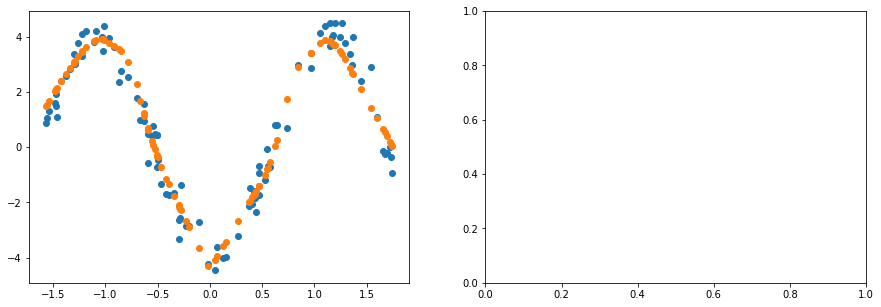

499 loss q(w) -91.004730 p(w) -244.179245 p(y|xw) -169.865173 min -5.140184 mean 0.302969 max 3.802577
499 loss q(w) -81.980576 p(w) -244.063538 p(y|xw) -130.122849 min -4.951797 mean 1.010161 max 4.212626
499 loss q(w) -87.041245 p(w) -243.593079 p(y|xw) -185.276138 min -5.184991 mean 0.593711 max 4.404165
499 loss q(w) -85.040375 p(w) -243.811157 p(y|xw) -419.502350 min -8.414510 mean 0.430808 max 4.017148
499 loss q(w) -103.859367 p(w) -242.668060 p(y|xw) -160.978424 min -3.224178 mean 1.089106 max 4.466637
499 loss q(w) -86.193604 p(w) -244.015244 p(y|xw) -155.019867 min -3.393543 mean 0.509820 max 3.764335
499 loss q(w) -85.036278 p(w) -244.004623 p(y|xw) -111.890244 min -3.221102 mean 1.026363 max 4.237421
499 loss q(w) -84.595421 p(w) -243.690598 p(y|xw) -151.439865 min -4.499094 mean 0.368301 max 3.592020
499 loss q(w) -100.223953 p(w) -243.678757 p(y|xw) -137.114685 min -3.616181 mean 1.015173 max 4.361062
499 loss q(w) -81.965271 p(w) -243.248581 p(y|xw) -181.258942 min -3.57

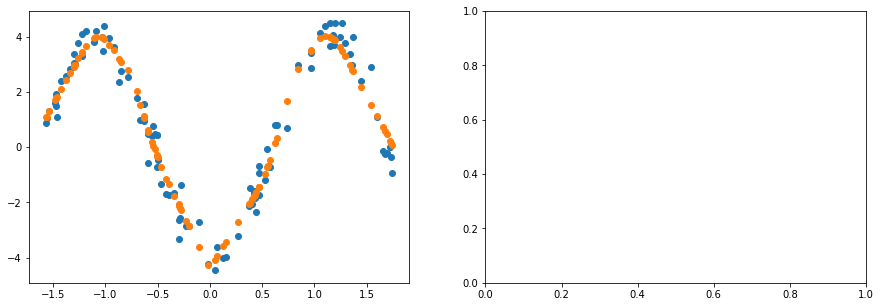

599 loss q(w) -72.271980 p(w) -243.929977 p(y|xw) -90.725594 min -4.165316 mean 1.047227 max 4.214746
599 loss q(w) -96.964516 p(w) -244.330276 p(y|xw) -135.254150 min -3.001315 mean 1.064237 max 4.195511
599 loss q(w) -100.651062 p(w) -244.688553 p(y|xw) -138.834412 min -4.960094 mean 0.599658 max 3.584381
599 loss q(w) -92.343063 p(w) -243.901993 p(y|xw) -209.365494 min -7.262740 mean 0.443196 max 3.649653
599 loss q(w) -77.231956 p(w) -244.690781 p(y|xw) -164.754486 min -4.298972 mean 1.052917 max 4.639665
599 loss q(w) -82.746506 p(w) -244.651901 p(y|xw) -81.070892 min -4.142557 mean 0.777999 max 4.336551
599 loss q(w) -81.471794 p(w) -244.712555 p(y|xw) -123.396675 min -4.371943 mean 0.644748 max 3.960146
599 loss q(w) -82.286812 p(w) -244.352310 p(y|xw) -204.653610 min -2.913107 mean 0.599204 max 3.630847
599 loss q(w) -91.987442 p(w) -244.754379 p(y|xw) -120.432281 min -3.443690 mean 1.078579 max 4.143362
599 loss q(w) -89.750755 p(w) -244.281891 p(y|xw) -157.975815 min -5.76640

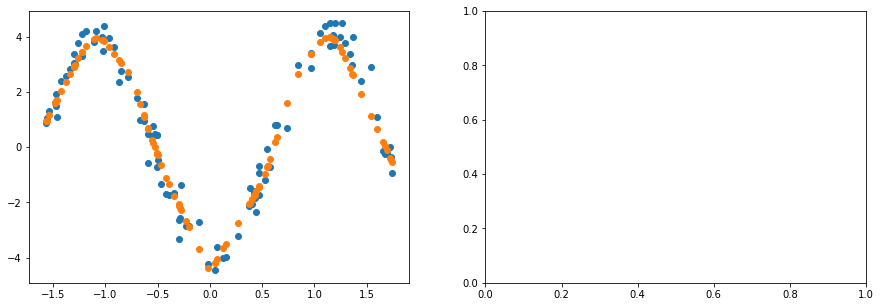

KeyboardInterrupt: ignored

In [18]:
def train():
    scaler = StandardScaler()
    x_train_norm = torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32)

    # model = LinearNet2()
    model = TensorLinearNet()
    vimodel = VIModel2(model)
    q_w = vimodel.dist
    p_w = normal_prior_distV2(model)

    # optimizer = torch.optim.Adam(params=vimodel.parameters(), lr=1e-4)
    optimizer = torch.optim.SGD(params=vimodel.parameters(), lr=1e-5, 
                                momentum=0.9,
                                weight_decay=1e-4)
    for i in range(10000):
        model.train()
        with torch.set_grad_enabled(True): 
            optimizer.zero_grad()        
            loss = kl_divergence_nsamples(q_w, p_w, vimodel.loc_dict, model, x_train_norm, y_train, i)
            loss.backward()
            optimizer.step()        
            
        if str(loss.item()) == 'nan':
            break

        if (i+1) % 100== 0:
            # mu = vimodel.eta_mu.detach().numpy()
            # sigma = torch.exp(vimodel.eta_log_sigma.detach()).numpy()
            # print('loss: %f mu: %s sigma: %s' % (loss.detach().numpy(), str(mu), str(sigma)))
            # print(loss.size())
            print('iter: %d loss: %f ' % (i, loss.item(),))

            plt_prediction(q_w, vimodel.loc_dict, model, x_train_norm, y_train, 30)

train()

In [0]:
for n, p in vimodel.named_parameters():
    print(n, p)

## prediction

Calculate prediction distribution
$$
\begin{align}
p(y_*| x_*, X, Y) &= \int p(y_*| x_*, W) p(W| X, Y) dW \\
&\approx \int p(y_*| x_*, W) q(W; \eta) dW 
\end{align}
$$

In [0]:
def predict_data(q_w, loc_dict, model, n_samples):    
    x_pred = 5 * torch.rand(100, 1)
    x_pred = torch.tensor(scaler.transform(x_pred), dtype=torch.float32)
    y_pred = predict(q_w, loc_dict, model, x_pred, n_samples)
    
    return x_pred, y_pred


In [0]:
x_pred, y_pred = predict_data(q_w, vimodel.loc_dict, model, 10)
y_pred_train = predict(q_w, vimodel.loc_dict, model, x_train_norm, 10)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
print(len(axes))
axes[0].plot(x_train_norm.numpy(), y_train.numpy(), 'o')
axes[0].plot(x_train_norm.numpy(), y_pred_train.numpy(), 'o')
axes[0].plot(x_pred.numpy(), y_pred.numpy(), 'o')